In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import re
import emoji

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

import torch
from torch.utils.data import DataLoader, Dataset

from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2025-10-09 19:04:35.698894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760036675.903577      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760036675.962160      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df=pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
df_valid=pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [4]:
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
df_valid.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [6]:
df = df.drop(['2401'], axis=1)
df_valid = df_valid.drop(['3364'], axis=1)

In [7]:
df["Borderlands"].unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [8]:
df["Borderlands"].value_counts()

Borderlands
Microsoft                            2400
MaddenNFL                            2400
TomClancysRainbowSix                 2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Overwatch                            2334
Xbox(Xseries)                        2334
johnson&johnson                      2328
Amazon                               2316
HomeDepot                            2310
PlayStation5(PS5)                    2310
CS-GO                                2304
Cyberpunk2077                        2304
GrandTheftAuto(GTA)   

In [9]:
df.columns = [ 'entity', 'sentiment', 'content']
df_valid.columns = [ 'entity', 'sentiment', 'content']

In [10]:
print(df['sentiment'].value_counts())
print(df_valid['sentiment'].value_counts())

sentiment
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64
sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    171
Name: count, dtype: int64


In [11]:
df.head()

,entity,sentiment,content
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


In [12]:
df.isna().sum()

entity         0
sentiment      0
content      686
dtype: int64

In [13]:
df=df.dropna()

In [14]:
df = df.drop_duplicates().reset_index(drop=True)
df_valid = df_valid.drop_duplicates().reset_index(drop=True)

In [15]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = emoji.demojize(text)  # Convert emojis to text (e.g., :) -> :smiling_face:)
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alpha/space
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

In [17]:
df['content'] = df['content'].apply(clean_text)
df_valid['content'] = df_valid['content'].apply(clean_text)

In [18]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df_valid['sentiment'] = label_encoder.fit_transform(df_valid['sentiment'])

In [19]:
tfidf = TfidfVectorizer(max_features=5000)
x_train_tfidf = tfidf.fit_transform(df['content']).toarray()
x_valid_tfidf = tfidf.transform(df_valid['content']).toarray()

y_train = df['sentiment'].values
y_valid=df_valid['sentiment'].values

In [20]:
x_train_lstm = np.expand_dims(x_train_tfidf, axis=1)
x_valid_lstm = np.expand_dims(x_valid_tfidf, axis=1)

In [21]:
num_classes = len(label_encoder.classes_)

lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])))
lstm_model.add(Dropout(0.7))
lstm_model.add(Dense(num_classes, activation='softmax'))

I0000 00:00:1760036718.131187      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760036718.131937      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
lstm_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-5
)

In [24]:
history = lstm_model.fit(
    x_train_lstm, y_train,
    validation_data=(x_valid_lstm, y_valid),
    epochs=100,    
    batch_size=64,
)

Epoch 1/100


I0000 00:00:1760036726.821914      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


1109/1109 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4776 - loss: 1.2120 - val_accuracy: 0.7447 - val_loss: 0.7040
Epoch 2/100
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6836 - loss: 0.8121 - val_accuracy: 0.7968 - val_loss: 0.5732
Epoch 3/100
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7217 - loss: 0.7166 - val_accuracy: 0.8298 - val_loss: 0.5268
Epoch 4/100
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7332 - loss: 0.6814 - val_accuracy: 0.8388 - val_loss: 0.4962
Epoch 5/100
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7449 - loss: 0.6536 - val_accuracy: 0.8398 - val_loss: 0.4754
Epoch 6/100
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7493 - loss: 0.6371 - val_accuracy: 0.8448 - val_loss: 0.4651
Epoch 7/100
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7588 - loss: 0.6201 - val_accuracy: 0.8609 - val_loss: 0.4520
Epoch 8/100
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7650 - loss: 0.6000 - val

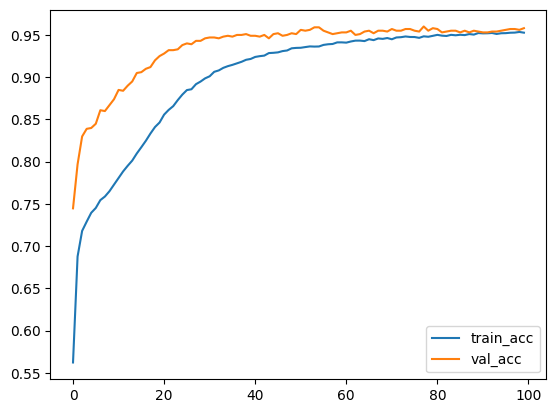

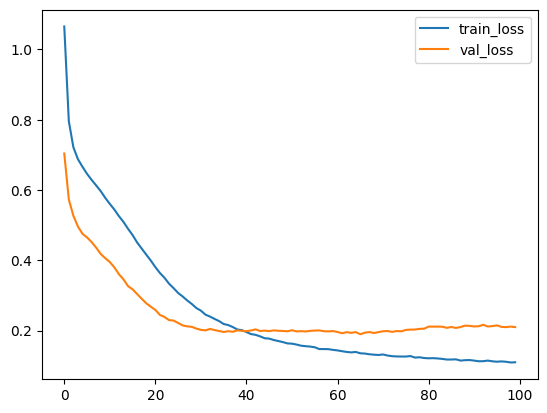

In [25]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [26]:
y_pred = lstm_model.predict(x_valid_lstm)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_classes, target_names=label_encoder.classes_))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

  Irrelevant       0.96      0.95      0.96       171
    Negative       0.98      0.97      0.98       266
     Neutral       0.97      0.94      0.96       285
    Positive       0.92      0.97      0.95       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999



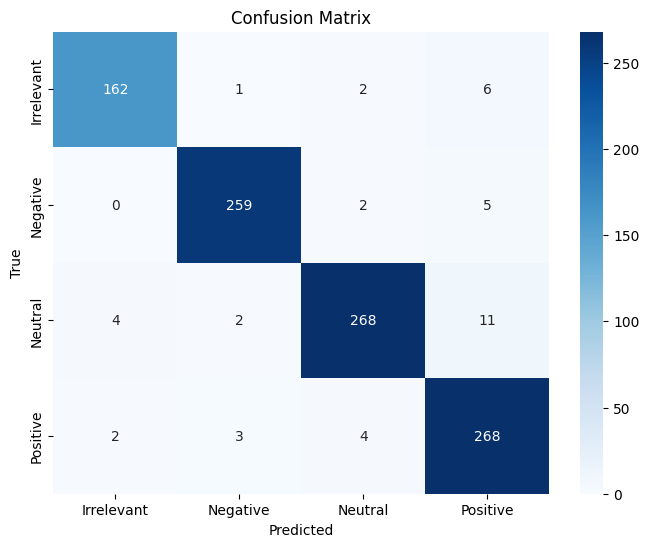

In [27]:
conf_matrix = confusion_matrix(y_valid, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
true_labels = label_encoder.inverse_transform(y_valid)
pred_labels = label_encoder.inverse_transform(y_pred_classes)

num_samples = 10  

sample_df = pd.DataFrame({
    'True Label': [true_labels[i] for i in indices],
    'Predicted Label': [pred_labels[i] for i in indices]
})

print(sample_df)

NameError: name 'indices' is not defined

In [ ]:
test_list=[ "I really loved this movie" #Positive 
           ,"This was the worst experience I’ve ever had."#Negative
           ,"The meeting is scheduled for tomorrow ."#Neutral
           ,"The sky is blue and the grass is green."#Irrelevant
          ]

In [ ]:
x_input = tfidf.transform(test_list).toarray()
x_input = np.expand_dims(x_input, axis=1)

In [ ]:
y_pred_probs = lstm_model.predict(x_input)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
predicted_labels = label_encoder.inverse_transform(y_pred_classes)

print(predicted_labels)